## Generation of MUBs for 2 and 3 qubits

In [31]:
from qiskit.opflow import X, Y, Z, I, PauliOp, PauliSumOp
from qsymm.linalg import simult_diag
import numpy as np
from bqskit.compiler import Compiler
from bqskit.compiler import CompilationTask

ModuleNotFoundError: No module named 'qsymm'

In [32]:
import os

MUB_CIRC_2_PATH = os.path.join(os.getcwd(), 'mub_bqskit', '2_302')
MUB_CIRC_3_PATH = os.path.join(os.getcwd(), 'mub_bqskit', '3_306')

The method in this section of the notebook is based on the paper 'Mutually unbiased binary observable sets on N qubits'
By Lawrence, Brukner and Zeilinger. (2022)

The paper provides a table. In that table, each row contains several Pauli strings.
The basis that this row represents is the eigenvector basis that diagonalizes **the entire row**.

Thus, this function applies simultaneous diagonalization to all matrices (Pauli strings) from each row, to get the MUB.
After that, BQSKit is used to synthesize a circuit that generates those MUB states.

In [3]:
def mats_to_mub_circ(mats_row: np.ndarray, nqubits: int):
    mub_uni = np.hstack(simult_diag(mats_row))
    task = CompilationTask.synthesize(mub_uni)
    with Compiler() as compiler:
        synth_qc = compiler.compile(task)
    return mub_uni, synth_qc.to('qasm')

In [ ]:
tbl_2_302 = [ [Z^I, I^Z, Z^Z],
        [X^I, I^Y, X^Y],
        [Y^I, I^X, Y^X],
        [Y^Y, Z^X, Z^X],
        [X^X, Y^Z, Z^Y]]

tbl_3_306 = [   # The full columns were not added, as to save space, since 3 matrices should define the basis completely.
    [X^I^I, I^Y^I, I^I^Z, X^Y^Z, X^Y^I, X^I^Z, I^Y^Z],  # First 3 rows are product state bases
    [Y^I^I, I^Z^I, I^I^X],
    [Z^I^I, I^X^I, I^I^Y],
    [Y^Z^Z, Z^Y^Z, Z^Z^Y],  # Last 6 rows are GHZ-like bases
    [Z^X^X, X^Z^X, X^X^Z],
    [X^Y^Y, Y^X^Y, Y^Y^X],
    [Z^X^Z, Y^X^X, Y^Y^Z],
    [X^Y^X, Z^Y^Y, Z^Z^X],
    [Y^Z^Y, X^Z^Z, X^X^Y]
]



qasm_2_302 = {}
qasm_3_306 = {}

print('----------RESULTS FOR 2-QUBIT MUBS (3,0,2)--------------')
for i, row in enumerate(tbl_2_302):
    res = mats_to_mub_circ(list(map(lambda p: p.to_matrix(), row)), 2)
    print(f'result for row {i+1}:')
    print(res[0])
    print(res[1])
    with open(os.path.join(MUB_CIRC_2_PATH, str(i+1)+'.txt'), 'w') as f:
        f.write(res[1])
    qasm_2_302[i+1] = res[1]
    print('\n')


print('----------RESULTS FOR 3-QUBIT MUBS (3,0,6)--------------')
for i, row in enumerate(tbl_3_306):
    res = mats_to_mub_circ(list(map(lambda p: p.to_matrix(), row)), 3)
    print(f'result for row {i+1}:')
    print(res[0])
    print(res[1])
    with open(os.path.join(MUB_CIRC_3_PATH, str(i+1) + '.txt'), 'w') as f:
        f.write(res[1])
    qasm_3_306[i+1] = res[1]
    print('\n')

## Barren Plateau Problems

In [2]:
import qiskit as qk
from qiskit import Aer, QuantumCircuit

from qiskit.circuit import Parameter, ClassicalRegister
from qiskit.circuit.library import EfficientSU2
from qiskit.utils import QuantumInstance
from qiskit.algorithms import VQE
from qiskit.algorithms.minimum_eigen_solvers.vqe import VQEResult
from qiskit.algorithms.optimizers import COBYLA
from typing import Tuple, List, Dict, Union
from scipy.optimize import minimize, OptimizeResult
import numpy as np
from random import random
import json
from pprint import pprint
import matplotlib.pyplot as plt
from ast import literal_eval
%matplotlib inline

NO_MUB_PATH = 'no_mub_results_3.txt'
N_QUBIT_NO_MUB_PATH = 'no_nub_results_n.txt'
PRE_MUB_PATH = 'prepend_mub_results_3.txt'
APP_MUB_PATH = 'append_mub_results_3.txt'

### Basic Barren Plateau Circuit for Variational Quantum Compilation

The ansatz circuit is taken from 'Cost Function Dependent Barren Plateaus in Shallow Parametrized Quantum Circuits' by Cerezo et al., 2021, Figure 4.

The attempted task is 'trivial' Variational Quantum Compilation.
Vartational Quantum Compilation gets some unitary $U$, and an ansatz $V(\theta)$, and attempts to find a value for $\theta$ such that $V(\theta)| 0 \rangle = U | 0 \rangle$.

In this case, we choose $U=I$.
Because we pick a *random* initial guess for $\theta$, we will experience the barren plateaus that occur when the $\theta$ values are away from the target.

Note, however, an important observation:
In order to actually use the 'value' of the different MUB starting points, the original value of the parameters needs to be constant (although random) for all experiments.

I took this specific problem from 'Effect of barren plateaus on gradient-free optimization' by Arrasmith et al. (2021).

In [34]:
def gen_vqc_ansatz(n_qubits: int, n_layers: int) -> QuantumCircuit:
    qc = qk.QuantumCircuit(n_qubits)

    idx = 0

    for i in range(n_qubits):
        theta = Parameter(f'theta_{idx}')
        idx += 1
        qc.ry(theta, i)
        

    for layer in range(n_layers):
        for i in range(0, n_qubits-1, 2):
            qc.cz(i, i+1)
        
        for i in range(n_qubits-1):
            theta1 = Parameter(f'theta_{idx}')
            idx += 1
            qc.ry(theta1, i)

        for i in range(1, n_qubits-1, 2):
                qc.cz(i, i+1)
            
        for i in range(1, n_qubits):
            theta2 = Parameter(f'theta_{idx}')
            idx += 1
            qc.ry(theta2, i)

    qc.measure_all()

    return qc


### Experimenting without MUBs

#### Experiment Functions

In [35]:
### Defining experiment values
n_qubits = 3
SHOTS = 8192
MAX_ITER = 10000
backend = Aer.get_backend('qasm_simulator')
qi = QuantumInstance(backend, shots=SHOTS)


# Returns the number of function evaluations it took for the method to converge.
def run_vqc_exp(qc: QuantumCircuit, n_qubits: int, n_layers: int, theta0: List[float], tol: float = 0.2) -> OptimizeResult:
    def get_val_from_theta(theta: List[float]) -> float:
        concrete_qc = qc.bind_parameters(theta)
        results = qi.execute(concrete_qc)
        return 1 - (results.get_counts().int_raw.get(0, 0) / SHOTS)


    res = minimize(get_val_from_theta,
        theta0,
        method='COBYLA',
        options={'maxiter': MAX_ITER},
        tol=0.2)

    return res




#### Experiments - 3 qubits, $n$ layers

In [ ]:
no_mub_res = {}
for n_layers in range(4, 13):
    print(f'RUNNING EXPERIMENT FOR {n_layers} LAYERS:')
    qc = gen_vqc_ansatz(n_qubits, n_layers)
    theta0 = [np.random.random() for _ in range(qc.num_parameters)]
    layer_res = run_vqc_exp(qc, n_qubits, n_layers, theta0, 0.2)

    no_mub_res[n_layers] = layer_res

#### Experiments - $n$ qubits, $n$ layers

In [4]:
n_qubit_no_mub_res = {}
for n_layers in range(4, 13):
    print(f'RUNNING EXPERIMENT FOR {n_layers} LAYERS:')
    qc = gen_vqc_ansatz(n_layers, n_layers)
    theta0 = [np.random.random() for _ in range(qc.num_parameters)]
    layer_res = run_vqc_exp(qc, n_layers, n_layers, theta0, 0.2)

    n_qubit_no_mub_res[n_layers] = layer_res

RUNNING EXPERIMENT FOR 4 LAYERS:
RUNNING EXPERIMENT FOR 5 LAYERS:
RUNNING EXPERIMENT FOR 6 LAYERS:
RUNNING EXPERIMENT FOR 7 LAYERS:
RUNNING EXPERIMENT FOR 8 LAYERS:
RUNNING EXPERIMENT FOR 9 LAYERS:
RUNNING EXPERIMENT FOR 10 LAYERS:
RUNNING EXPERIMENT FOR 11 LAYERS:
RUNNING EXPERIMENT FOR 12 LAYERS:


### Analysis Functions

In [36]:
def avg(col):
    return sum(col) / len(col) if len(col) > 0 else None

def wavg(col, weights):
    assert len(col) == len(weights)
    return sum([v * w for v,w in zip(col, weights)])

def nfev(record: Union[VQEResult, OptimizeResult]) -> int:
    if type(record) == VQEResult:
        return record.cost_function_evals
    else:
        # print(f'RECORD TYPE IS {type(record)}, dir is {dir(record)}')
        assert type(record) == OptimizeResult
        return record.nfev


def gen_statistics_nomub(results_dict: Dict[int, VQEResult], filename: str = NO_MUB_PATH):
    res = {l: {'nfev': nfev(res)} for l, res in results_dict.items()}
    with open(filename, 'w') as f:
        pprint(res, f)
    return res

# Analyze the performance of appending MUB transformations to an ansatz
def gen_statistics_prepending(prepend_results_dict: Dict[int, Dict[int, Dict[int, VQEResult]]],
no_mub_stats: Dict[int, Dict[str, int]],
filename: str = APP_MUB_PATH) -> Dict[int, Dict[str, any]]:

    prepend_stats = {}
    for l, d_l in prepend_results_dict.items():
        layer_stats = {}
        # print(f'nfev for {l} layers')
        min_nfev = min([min([nfev(state_res) for state_res in d_mub.values()]) for d_mub in d_l.values()])
        layer_stats['min_nfev'] = min_nfev
        # All MUBs have the same amount of states, so a repeated average is mathematically valid
        layer_stats['avg_nfev'] = avg([avg([nfev(state_res) for state_res in d_mub.values()]) for d_mub in d_l.values()])

        adv_states = {}
        adv_states_flat = []
        for mub_idx, d_mub in d_l.items():
            adv_states[mub_idx] = {state: nfev(state_res) for state, state_res in d_mub.items() if nfev(state_res) < no_mub_stats[l]['nfev']}
            adv_states_flat += [nfev(state_res) for state_res in d_mub.values() if nfev(state_res) < no_mub_stats[l]['nfev']]
            
        layer_stats['adv_states'] = adv_states
        layer_stats['adv_states_count'] = len(adv_states_flat)
        layer_stats['adv_addition_percent'] = len(adv_states_flat) / ((2 ** n_qubits + 1) * (2 ** n_qubits))
        layer_stats['adv_avg_nfev'] = avg(adv_states_flat)
        # print(f'minimal nfev for {l} layers is {min_nfev}')
        prepend_stats[l] = layer_stats

    with open(filename, 'w') as f:
        # f.write(str(all_append_mub_results))
        # f.write('\n\n=====SUMMARY=====\n\n')
        pprint(prepend_stats, f)

    return prepend_stats


# Analyze the performance of appending MUB transformations to an ansatz
def gen_statistics_appending(append_results_dict: Dict[int, Dict[int, VQEResult]],
no_mub_stats: Dict[int, Dict[str, int]],
filename: str = PRE_MUB_PATH) -> Dict[int, Dict[str, any]]:

    append_stats = {}
    for l, d_l in append_results_dict.items():
        layer_stats = {}
        # print(f'nfev for {l} layers')
        min_nfev = min([nfev(mub_res) for mub_res in d_l.values()])
        layer_stats['min_nfev'] = min_nfev
        layer_stats['avg_nfev'] = avg([nfev(mub_res) for mub_res in d_l.values()])

        adv_mubs = {mub_idx: nfev(mub_res) for mub_idx, mub_res in d_l.items() if nfev(mub_res) < no_mub_stats[l]['nfev']}
        adv_mubs_count = len(adv_mubs)
        layer_stats['adv_mubs'] = adv_mubs
        layer_stats['adv_mubs_count'] = adv_mubs_count
        layer_stats['adv_addition_percent'] = adv_mubs_count / (2 ** n_qubits + 1)
        layer_stats['adv_avg_nfev'] = avg([nfev(mub_res) for mub_res in d_l.values() if nfev(mub_res) < no_mub_stats[l]['nfev']])
        # print(f'minimal nfev for {l} layers is {min_nfev}')
        append_stats[l] = layer_stats

    with open(filename, 'w') as f:
        # f.write(str(all_append_mub_results))
        # f.write('\n\n=====SUMMARY=====\n\n')
        pprint(append_stats, f)
    
    return append_stats

#### Analysis

In [14]:
filename = os.path.join(os.getcwd(), 'VQC results', NO_MUB_PATH)
no_mub_stats = gen_statistics_nomub(no_mub_res, filename=filename)

In [21]:
filename = os.path.join(os.getcwd(), 'VQC results', N_QUBIT_NO_MUB_PATH)
n_qubit_no_mub_stats = gen_statistics_nomub(n_qubit_no_mub_res, filename=filename)

## Mitigating Barren Plateaus using MUBs

### Loading the QASM MUB circuits into Qiskit

In [37]:
CIRC_FROM_FILES = True
if CIRC_FROM_FILES:
    paths = os.listdir(MUB_CIRC_3_PATH)
    circuits = [qk.circuit.QuantumCircuit.from_qasm_file(os.path.join(MUB_CIRC_3_PATH,path)) for path in paths if '.txt' in path]
else:
    circuits = [qk.circuit.QuantumCircuit.from_qasm_str(qasm_str) for qasm_str in qasm_3_306.values()]
    

### Experimenting with MUBs - prepending
This is an experiment in which a MUB transformation is applied *before* the ansatz circuits.

#### Experiment Functions

In [38]:
# This function gets a number i from 0 to (2^n)-1
# and returns a circuit that generates the state |i> when acting on |0>.
def get_comp_state_circ(state_idx: int, n_qubits: int) -> QuantumCircuit:
    qc = QuantumCircuit(n_qubits)
    bin_str = bin(state_idx)[2:].zfill(n_qubits)
    for i, ch in enumerate(bin_str):
        if ch == '1':
            qc.x(i)
    return qc

def run_vqc_exp_with_mub_prepend(ansatz_qc: QuantumCircuit, mub_qc: QuantumCircuit, n_qubits: int, n_layers: int, theta0: List[float], tol: float = 0.2) -> dict:
    mub_qc = mub_qc.copy()
    mub_qc.add_register(ClassicalRegister(n_qubits))
    mub_ansatz_qc = mub_qc.compose(ansatz_qc, qubits=range(n_qubits), inplace=False)
    assert mub_ansatz_qc != None

    res_dict = {}
    for i in range((2 ** n_qubits)):
        starting_qc = get_comp_state_circ(i, n_qubits)
        starting_qc.add_register(ClassicalRegister(n_qubits))
        full_qc = starting_qc.compose(mub_ansatz_qc, qubits=range(n_qubits), inplace=False)
        assert full_qc != None
        res_dict[i] = run_vqc_exp(full_qc, n_qubits, n_layers, theta0, tol)

    return res_dict

#### Experiments

In [ ]:
print('=====Experimenting with prepended MUB states=====')
all_prepend_mub_results = {}
for n_layers in range(4,13):
    layer_results = {}
    print(f'---experimenting with {n_layers} layers---')
    ansatz = gen_vqc_ansatz(n_qubits, n_layers)
    theta0 = [np.random.random() for _ in range(ansatz.num_parameters)]
    for i, mub_circuit in enumerate(circuits):
        print(f'experimenting with MUB #{i+1}')
        res = run_vqc_exp_with_mub_prepend(ansatz, mub_circuit, n_qubits, n_layers, theta0, tol=0.2)
        # print(res)
        print(f'MUB #{i+1} done')
        layer_results[i] = res
    all_prepend_mub_results[n_layers] = layer_results

#### Analysis

In [15]:
filename = os.path.join(os.getcwd(), 'VQC results', PRE_MUB_PATH)
prepend_stats = gen_statistics_prepending(all_prepend_mub_results, no_mub_stats, filename=filename)

### Experimenting with MUBs - appending
Now, instead of generating MUB states at the beginning, we add MUB transformations at the end.
Let's see how that goes.

Seeing as state initial sate preparation does not take place, there is no meaning for each individual state.

#### Experiment Functions

In [39]:
def run_vqc_exp_with_mub_append(ansatz_qc: QuantumCircuit, mub_qc: QuantumCircuit, n_qubits: int, n_layers: int, theta0: List[float], tol: float = 0.2) -> dict:
    mub_qc = mub_qc.copy()
    mub_qc.add_register(ClassicalRegister(n_qubits))
    mub_ansatz_qc = mub_qc.compose(ansatz_qc, qubits=range(n_qubits), inplace=False)
    assert mub_ansatz_qc != None
    
    return run_vqc_exp(mub_ansatz_qc, n_qubits, n_layers, theta0, tol)

#### Experiments

In [40]:
print('=====Experimenting with appended MUB states=====')
all_append_mub_results = {}
for n_layers in range(4,13):
    layer_results = {}
    print(f'---experimenting with {n_layers} layers---')
    ansatz = gen_vqc_ansatz(n_qubits, n_layers)
    theta0 = [np.random.random() for _ in range(ansatz.num_parameters)]
    for i, mub_circuit in enumerate(circuits):
        print(f'experimenting with MUB #{i+1}')
        res = run_vqc_exp_with_mub_append(ansatz, mub_circuit, n_qubits, n_layers, theta0, tol=0.2)
        # print(res)
        print(f'MUB #{i+1} done')
        layer_results[i] = res
    all_append_mub_results[n_layers] = layer_results

=====Experimenting with appended MUB states=====
---experimenting with 4 layers---
experimenting with MUB #1
MUB #1 done
experimenting with MUB #2
MUB #2 done
experimenting with MUB #3
MUB #3 done
experimenting with MUB #4
MUB #4 done
experimenting with MUB #5
MUB #5 done
experimenting with MUB #6
MUB #6 done
experimenting with MUB #7
MUB #7 done
experimenting with MUB #8
MUB #8 done
experimenting with MUB #9
MUB #9 done
---experimenting with 5 layers---
experimenting with MUB #1
MUB #1 done
experimenting with MUB #2
MUB #2 done
experimenting with MUB #3
MUB #3 done
experimenting with MUB #4
MUB #4 done
experimenting with MUB #5
MUB #5 done
experimenting with MUB #6
MUB #6 done
experimenting with MUB #7
MUB #7 done
experimenting with MUB #8
MUB #8 done
experimenting with MUB #9
MUB #9 done
---experimenting with 6 layers---
experimenting with MUB #1
MUB #1 done
experimenting with MUB #2
MUB #2 done
experimenting with MUB #3
MUB #3 done
experimenting with MUB #4
MUB #4 done
experimenting

#### Analysis

In [41]:
filename = os.path.join(os.getcwd(), 'VQC results', APP_MUB_PATH)
append_stats = gen_statistics_appending(all_append_mub_results, no_mub_stats, filename=filename)

## Collective Experiments - VQC

### Plotting Functions

In [7]:
def myplot(data: dict, label: str):
    data = {k: v for k,v in data.items() if v != None}
    lists = sorted(data.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    plt.plot(x, y, label=label, marker='o')

### (Optionally) Load Data Fom Files

In [8]:
from ast import literal_eval

STATS_FROM_FILES = True

def load_stats(name: str) -> dict:
    filename = os.path.join(os.getcwd(), 'VQC results', name)
    with open(filename, 'r') as f:
        data = f.read()
    
    return literal_eval(data)

if STATS_FROM_FILES:
    no_mub_stats = load_stats(NO_MUB_PATH)
    prepend_stats = load_stats(PRE_MUB_PATH)
    append_stats = load_stats(APP_MUB_PATH)
    n_qubit_no_mub_stats = load_stats(N_QUBIT_NO_MUB_PATH)

### Raw Summary Data

In [9]:
print('No MUBs:')
print(no_mub_stats)
print('n-qubit, n-layer, No MUBs:')
print(n_qubit_no_mub_stats)
print('Prepended MUB states:')
print(prepend_stats)
print('Appended MUB transformations:')
print(append_stats)

No MUBs:
{4: {'nfev': 87}, 5: {'nfev': 98}, 6: {'nfev': 108}, 7: {'nfev': 128}, 8: {'nfev': 127}, 9: {'nfev': 162}, 10: {'nfev': 144}, 11: {'nfev': 223}, 12: {'nfev': 175}}
n-qubit, n-layer, No MUBs:
{4: {'nfev': 164}, 5: {'nfev': 192}, 6: {'nfev': 311}, 7: {'nfev': 499}, 8: {'nfev': 882}, 9: {'nfev': 1167}, 10: {'nfev': 1162}, 11: {'nfev': 1635}, 12: {'nfev': 2340}}
Prepended MUB states:
{4: {'adv_addition_percent': 0.8333333333333334, 'adv_avg_nfev': 71.26666666666667, 'adv_states': {0: {0: 77, 1: 68, 2: 55, 3: 63, 4: 72, 5: 76, 6: 80, 7: 78}, 1: {0: 70, 1: 75, 2: 82, 3: 81, 4: 70, 7: 77}, 2: {5: 86, 6: 62}, 3: {0: 62, 1: 74, 2: 73, 3: 79, 4: 70, 5: 69, 6: 79, 7: 72}, 4: {0: 65, 1: 65, 2: 85, 7: 84}, 5: {0: 71, 1: 63, 2: 70, 3: 77, 4: 79, 5: 72, 6: 63, 7: 80}, 6: {0: 69, 1: 65, 2: 65, 3: 71, 4: 82, 5: 71, 6: 61, 7: 58}, 7: {0: 78, 1: 70, 2: 80, 3: 77, 4: 68, 5: 68, 6: 64, 7: 75}, 8: {0: 70, 1: 60, 2: 71, 3: 62, 4: 64, 5: 66, 6: 61, 7: 76}}, 'adv_states_count': 60, 'avg_nfev': 75.4027

### Minimal \# Of Function Evals

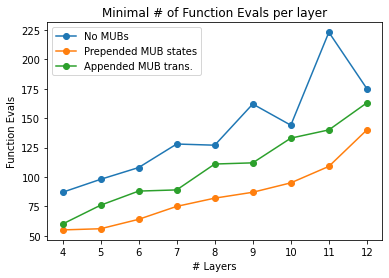

In [10]:
def plot_min_nfev(stats_dict: Dict[int, Dict[str, any]], label: str):
    for v in stats_dict.values():
        assert 'min_nfev' in v.keys() or 'nfev' in v.keys()
    nfev_dict = {k: v['min_nfev'] if 'min_nfev' in v.keys() else v['nfev'] for k,v in stats_dict.items()}
    myplot(nfev_dict, label)

plt.xlabel('# Layers')
plt.ylabel('Function Evals')
plt.title('Minimal # of Function Evals per layer')
plot_min_nfev(no_mub_stats, 'No MUBs')
plot_min_nfev(prepend_stats, 'Prepended MUB states')
plot_min_nfev(append_stats, 'Appended MUB trans.')
plt.legend()
plt.show()

### Average \# Of Function Evals

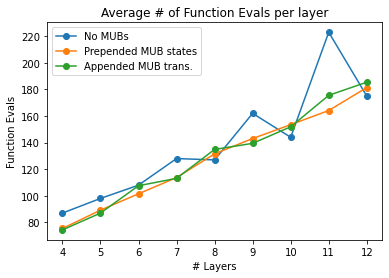

In [11]:
def plot_avg_nfev(stats_dict: Dict[int, Dict[str, any]], label: str):
    avg_nfev_dict = {k: v['avg_nfev'] if 'avg_nfev' in v.keys() else v['nfev'] for k,v in stats_dict.items()}
    myplot(avg_nfev_dict, label)

plt.xlabel('# Layers')
plt.ylabel('Function Evals')
plt.title('Average # of Function Evals per layer')
plot_avg_nfev(no_mub_stats, 'No MUBs')
plot_avg_nfev(prepend_stats, 'Prepended MUB states')
plot_avg_nfev(append_stats, 'Appended MUB trans.')
plt.legend()
plt.show()

### Percent of Advantageous Additions

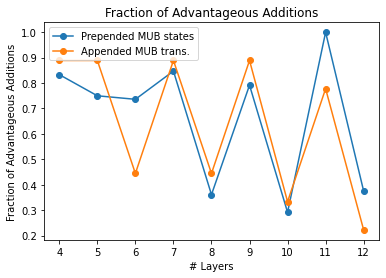

In [12]:
def plot_adv_percent(stats_dict: Dict[int, Dict[str, any]], label: str):
    adv_percent_dict = {k: v['adv_addition_percent'] for k,v in stats_dict.items()}
    myplot(adv_percent_dict, label)
    
plt.xlabel('# Layers')
plt.ylabel('Fraction of Advantageous Additions')
plt.title('Fraction of Advantageous Additions')
plot_adv_percent(prepend_stats, 'Prepended MUB states')
plot_adv_percent(append_stats, 'Appended MUB trans.')
plt.legend()
plt.show()

### Average \# Of Function Evals in Advantageous Additions

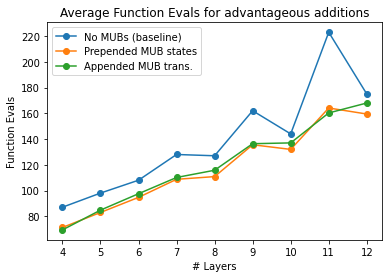

In [13]:
def plot_adv_avg_nfev(stats_dict: Dict[int, Dict[str, any]], label: str):
    adv_percent_dict = {k: v['adv_avg_nfev'] for k,v in stats_dict.items()}
    myplot(adv_percent_dict, label)
    
plt.xlabel('# Layers')
plt.ylabel('Function Evals')
plt.title('Average Function Evals for advantageous additions')
plot_min_nfev(no_mub_stats, 'No MUBs (baseline)')
plot_adv_avg_nfev(prepend_stats, 'Prepended MUB states')
plot_adv_avg_nfev(append_stats, 'Appended MUB trans.')
plt.legend()
plt.show()

### Summary: MUB Prepending

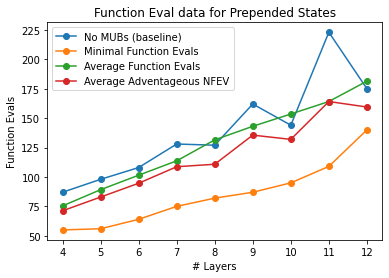

In [14]:
plot_min_nfev(no_mub_stats, 'No MUBs (baseline)')
plot_min_nfev(prepend_stats, 'Minimal Function Evals')
plot_avg_nfev(prepend_stats, 'Average Function Evals')
plot_adv_avg_nfev(prepend_stats, 'Average Adventageous NFEV')
plt.xlabel('# Layers')
plt.ylabel('Function Evals')
plt.title('Function Eval data for Prepended States')
plt.legend()
plt.show()

### Summary: MUB Appending

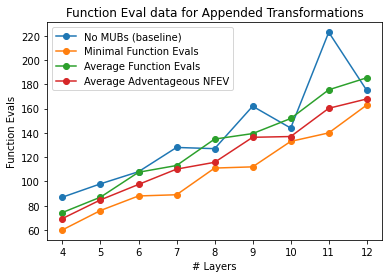

In [15]:
plot_min_nfev(no_mub_stats, 'No MUBs (baseline)')
plot_min_nfev(append_stats, 'Minimal Function Evals')
plot_avg_nfev(append_stats, 'Average Function Evals')
plot_adv_avg_nfev(append_stats, 'Average Adventageous NFEV')
plt.xlabel('# Layers')
plt.ylabel('Function Evals')
plt.title('Function Eval data for Appended Transformations')
plt.legend()
plt.show()

### $n$ qubits and $n$ layers: # Function Evals

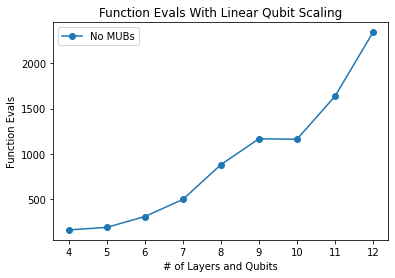

In [16]:
plot_min_nfev(n_qubit_no_mub_stats, 'No MUBs')
plt.xlabel('# of Layers and Qubits')
plt.ylabel('Function Evals')
plt.title('Function Evals With Linear Qubit Scaling')
plt.legend()
plt.show()

## Basic Barren Plateau Circuit for Transverse Ising VQE
To save myself some time, I'll just use the built-in VQE module.

In [42]:
def build_pauli_string(n_qubits: int, mat_locations: Dict[int, str]) -> str:
    assert n_qubits > 0
    H = ''
    for i in range(n_qubits):
        H += mat_locations.get(i, 'I')
    return H

def generate_transverse_ising_ham(n_qubits: int) -> PauliSumOp:
    # Build Individual X strings
    string_list = [(build_pauli_string(n_qubits, {i: 'X'}), random()) for i in range(n_qubits)]
    for i in range(n_qubits):
        string_list += [(build_pauli_string(n_qubits, {i: 'Z', j: 'Z'}), random()) for j in range(i+1, n_qubits)]
    return PauliSumOp.from_list(string_list, 1)

In [43]:
## For now, I'm using the standard qiskit hardware efficient ansatz (as Dekel suggested).
def gen_hardware_eff_ansatz(n_qubits: int, n_layers: int) -> QuantumCircuit:
    qc = QuantumCircuit(n_qubits)
    ansatz = EfficientSU2(n_qubits, reps=n_layers, entanglement='linear')
    qc.compose(ansatz, inplace=True)
    return qc

### Experimenting without MUBs

#### Experiment Functions

In [44]:
# Returns the number of function evaluations it took for the method to converge.
def run_vqe_exp(ansatz: QuantumCircuit, ham: PauliSumOp, theta0: Union[List[float], None] = None, tol: float = 0.2) -> VQEResult:
    optimizer = COBYLA(tol=tol)
    vqe = VQE(ansatz=ansatz, optimizer=optimizer, quantum_instance=qi, initial_point=np.asarray(theta0))
    result = vqe.compute_minimum_eigenvalue(operator=ham)
    return result

#### Experiments

In [ ]:
no_mub_res = {}

for n_layers in range(4, 13):
    print(f'RUNNING VQE EXPERIMENT FOR {n_layers} LAYERS:')
    # n_qubits = n_layers
    ham = generate_transverse_ising_ham(n_qubits)
    ansatz = gen_hardware_eff_ansatz(n_qubits, n_layers)
    theta0 = [np.random.random() for _ in range(ansatz.num_parameters)]
    layer_res = run_vqe_exp(ansatz, ham, theta0=theta0, tol=0.2)
    no_mub_res[n_layers] = layer_res

In [45]:
n_qubit_no_mub_res = {}
for n_layers in range(4, 13):
    print(f'RUNNING EXPERIMENT FOR {n_layers} LAYERS:')
    qc = gen_vqc_ansatz(n_layers, n_layers)
    theta0 = [np.random.random() for _ in range(qc.num_parameters)]
    layer_res = run_vqc_exp(qc, n_layers, n_layers, theta0, 0.2)

    n_qubit_no_mub_res[n_layers] = layer_res

RUNNING EXPERIMENT FOR 4 LAYERS:
RUNNING EXPERIMENT FOR 5 LAYERS:
RUNNING EXPERIMENT FOR 6 LAYERS:
RUNNING EXPERIMENT FOR 7 LAYERS:
RUNNING EXPERIMENT FOR 8 LAYERS:
RUNNING EXPERIMENT FOR 9 LAYERS:
RUNNING EXPERIMENT FOR 10 LAYERS:
RUNNING EXPERIMENT FOR 11 LAYERS:
RUNNING EXPERIMENT FOR 12 LAYERS:


#### Analysis

In [89]:
filename = os.path.join(os.getcwd(), 'VQE results', NO_MUB_PATH)
no_mub_stats = gen_statistics_nomub(no_mub_res, filename=filename)

In [50]:
filename = os.path.join(os.getcwd(), 'VQE results', N_QUBIT_NO_MUB_PATH)
n_qubit_no_mub_stats = gen_statistics_nomub(n_qubit_no_mub_res, filename=filename)

### Experimenting with MUBs - prepending (VQE)

#### Experiment Functions

In [58]:
def run_vqe_exp_with_mub_prepend(ansatz_qc: QuantumCircuit, mub_qc: QuantumCircuit, n_qubits: int, ham: PauliSumOp, theta0: Union[List[float], None] = None, tol: float = 0.2) -> dict:
    mub_qc = mub_qc.copy()
    mub_ansatz_qc = mub_qc.compose(ansatz_qc, qubits=range(n_qubits), inplace=False)
    assert mub_ansatz_qc != None

    res_dict = {}
    for i in range((2 ** n_qubits)):
        starting_qc = get_comp_state_circ(i, n_qubits)
        full_qc = starting_qc.compose(mub_ansatz_qc, qubits=range(n_qubits), inplace=False)
        assert full_qc != None
        res_dict[i] = run_vqe_exp(full_qc, ham, theta0=theta0, tol=tol)

    return res_dict

#### Experiments

In [ ]:
print('=====Experimenting with prepended MUB states=====')
ham = generate_transverse_ising_ham(n_qubits)
all_prepend_mub_results = {}

for n_layers in range(4,13):
    print(f'---experimenting with {n_layers} layers---')
    layer_results = {}
    ansatz = gen_hardware_eff_ansatz(n_qubits, n_layers)
    theta0 = [np.random.random() for _ in range(ansatz.num_parameters)]
    for i, mub_circuit in enumerate(circuits):
        print(f'experimenting with MUB #{i+1}')
        res = run_vqe_exp_with_mub_prepend(ansatz, mub_circuit, n_qubits, ham, theta0=theta0, tol=0.2)
        # print(res)
        print(f'MUB #{i+1} done')
        layer_results[i] = res
    all_prepend_mub_results[n_layers] = layer_results

#### Analysis

In [65]:
filename = os.path.join(os.getcwd(), 'VQE results', PRE_MUB_PATH)
prepend_stats = gen_statistics_prepending(all_prepend_mub_results, no_mub_stats, filename=filename)

### Experimenting with MUBs - appending

#### Experiment Functions

In [90]:
def run_vqe_exp_with_mub_append(ansatz_qc: QuantumCircuit, mub_qc: QuantumCircuit, n_qubits: int, ham: PauliSumOp, theta0: Union[List[float], None] = None, tol: float = 0.2) -> VQEResult:
    mub_qc = mub_qc.copy()
    mub_ansatz_qc = mub_qc.compose(ansatz_qc, qubits=range(n_qubits), inplace=False)
    assert mub_ansatz_qc != None
    
    return run_vqe_exp(mub_ansatz_qc, ham, theta0, tol)

#### Experiments

In [ ]:
print('=====Experimenting with appended MUB states=====')
ham = generate_transverse_ising_ham(n_qubits)
all_append_mub_results = {}

for n_layers in range(4,13):
    print(f'---experimenting with {n_layers} layers---')
    layer_results = {}
    ansatz = gen_hardware_eff_ansatz(n_qubits, n_layers)
    theta0 = [np.random.random() for _ in range(ansatz.num_parameters)]
    for i, mub_circuit in enumerate(circuits):
        print(f'experimenting with MUB #{i+1}')
        res = run_vqe_exp_with_mub_append(ansatz, mub_circuit, n_qubits, ham, theta0=theta0, tol=0.2)
        # print(res)
        print(f'MUB #{i+1} done')
        layer_results[i] = res
    all_append_mub_results[n_layers] = layer_results

#### Analysis

In [95]:
filename = os.path.join(os.getcwd(), 'VQE results', APP_MUB_PATH)
append_stats = gen_statistics_appending(all_append_mub_results, no_mub_stats, filename=filename)

## Collective Experiments - VQE

### (Optionally) Load Data Fom Files

In [17]:
STATS_FROM_FILES = True

def load_stats(name: str) -> dict:
    filename = os.path.join(os.getcwd(), 'VQE results', name)
    with open(filename, 'r') as f:
        data = f.read()
    
    return literal_eval(data)

if STATS_FROM_FILES:
    no_mub_stats = load_stats(NO_MUB_PATH)
    prepend_stats = load_stats(PRE_MUB_PATH)
    append_stats = load_stats(APP_MUB_PATH)
    n_qubit_no_mub_stats = load_stats(N_QUBIT_NO_MUB_PATH)

### Raw Summary Data

In [18]:
print('No MUBs:')
print(no_mub_stats)
print('Prepended MUB states:')
print(prepend_stats)
print('Appended MUB transformations:')
print(append_stats)

No MUBs:
{4: {'nfev': 121}, 5: {'nfev': 126}, 6: {'nfev': 168}, 7: {'nfev': 172}, 8: {'nfev': 189}, 9: {'nfev': 264}, 10: {'nfev': 220}, 11: {'nfev': 274}, 12: {'nfev': 273}}
Prepended MUB states:
{4: {'adv_addition_percent': 0.3472222222222222, 'adv_avg_nfev': 110.56, 'adv_states': {0: {1: 104, 2: 104, 5: 93}, 1: {1: 110, 6: 114}, 2: {}, 3: {2: 110, 5: 112, 7: 112}, 4: {1: 110, 2: 108, 3: 110, 5: 114, 6: 122}, 5: {4: 108, 5: 100}, 6: {1: 111, 6: 122, 7: 110}, 7: {0: 116, 4: 110, 6: 110, 7: 120}, 8: {1: 108, 4: 110, 6: 116}}, 'adv_states_count': 25, 'avg_nfev': 132.15277777777777, 'min_nfev': 93}, 5: {'adv_addition_percent': 0.2777777777777778, 'adv_avg_nfev': 128.8, 'adv_states': {0: {3: 130, 4: 128, 6: 118}, 1: {0: 136, 1: 122, 2: 132, 4: 134}, 2: {6: 126}, 3: {3: 124}, 4: {2: 130, 4: 133, 5: 130}, 5: {1: 126, 3: 126}, 6: {1: 134}, 7: {4: 128, 5: 132}, 8: {1: 135, 2: 128, 3: 124}}, 'adv_states_count': 20, 'avg_nfev': 152.33333333333334, 'min_nfev': 118}, 6: {'adv_addition_percent': 0

### Minimal \# Of Function Evals

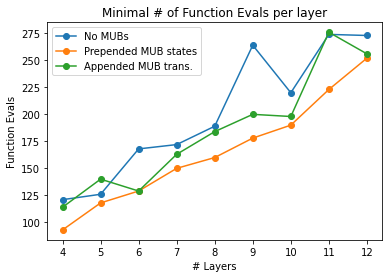

In [19]:
def plot_min_nfev(stats_dict: Dict[int, Dict[str, any]], label: str):
    for v in stats_dict.values():
        assert 'min_nfev' in v.keys() or 'nfev' in v.keys()
    nfev_dict = {k: v['min_nfev'] if 'min_nfev' in v.keys() else v['nfev'] for k,v in stats_dict.items()}
    myplot(nfev_dict, label)

plt.xlabel('# Layers')
plt.ylabel('Function Evals')
plt.title('Minimal # of Function Evals per layer')
plot_min_nfev(no_mub_stats, 'No MUBs')
plot_min_nfev(prepend_stats, 'Prepended MUB states')
plot_min_nfev(append_stats, 'Appended MUB trans.')
plt.legend()
plt.show()

### Average \# Of Function Evals

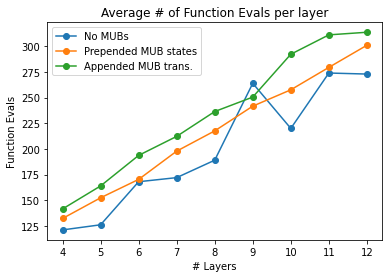

In [20]:
def plot_avg_nfev(stats_dict: Dict[int, Dict[str, any]], label: str):
    avg_nfev_dict = {k: v['avg_nfev'] if 'avg_nfev' in v.keys() else v['nfev'] for k,v in stats_dict.items()}
    myplot(avg_nfev_dict, label)

plt.xlabel('# Layers')
plt.ylabel('Function Evals')
plt.title('Average # of Function Evals per layer')
plot_avg_nfev(no_mub_stats, 'No MUBs')
plot_avg_nfev(prepend_stats, 'Prepended MUB states')
plot_avg_nfev(append_stats, 'Appended MUB trans.')
plt.legend()
plt.show()

### Percent of Advantageous Additions

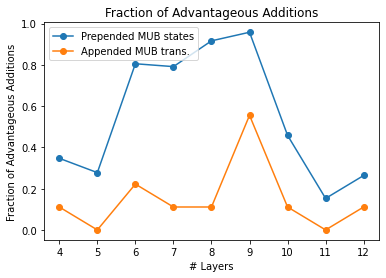

In [21]:
def plot_adv_percent(stats_dict: Dict[int, Dict[str, any]], label: str):
    adv_percent_dict = {k: v['adv_addition_percent'] for k,v in stats_dict.items()}
    myplot(adv_percent_dict, label)
    
plt.xlabel('# Layers')
plt.ylabel('Fraction of Advantageous Additions')
plt.title('Fraction of Advantageous Additions')
plot_adv_percent(prepend_stats, 'Prepended MUB states')
plot_adv_percent(append_stats, 'Appended MUB trans.')
plt.legend()
plt.show()

### Average \# Of Function Evals in Advantageous Additions

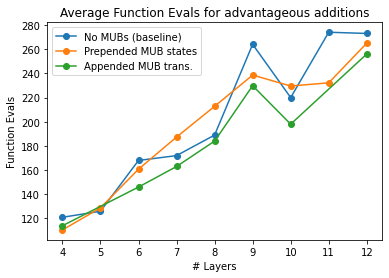

In [22]:
def plot_adv_avg_nfev(stats_dict: Dict[int, Dict[str, any]], label: str):
    adv_percent_dict = {k: v['adv_avg_nfev'] for k,v in stats_dict.items()}
    myplot(adv_percent_dict, label)
    
plt.xlabel('# Layers')
plt.ylabel('Function Evals')
plt.title('Average Function Evals for advantageous additions')
plot_min_nfev(no_mub_stats, 'No MUBs (baseline)')
plot_adv_avg_nfev(prepend_stats, 'Prepended MUB states')
plot_adv_avg_nfev(append_stats, 'Appended MUB trans.')
plt.legend()
plt.show()

### Summary: MUB Prepending

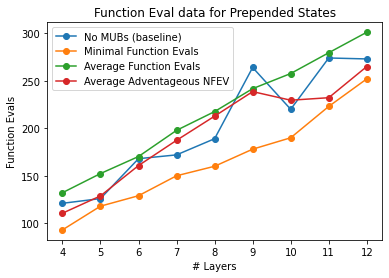

In [23]:
plot_min_nfev(no_mub_stats, 'No MUBs (baseline)')
plot_min_nfev(prepend_stats, 'Minimal Function Evals')
plot_avg_nfev(prepend_stats, 'Average Function Evals')
plot_adv_avg_nfev(prepend_stats, 'Average Adventageous NFEV')
plt.xlabel('# Layers')
plt.ylabel('Function Evals')
plt.title('Function Eval data for Prepended States')
plt.legend()
plt.show()

### Summary: MUB Appending

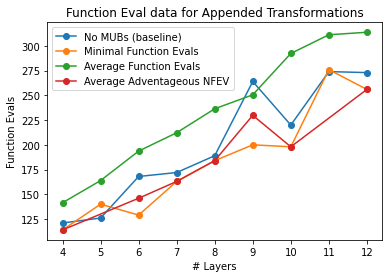

In [24]:
plot_min_nfev(no_mub_stats, 'No MUBs (baseline)')
plot_min_nfev(append_stats, 'Minimal Function Evals')
plot_avg_nfev(append_stats, 'Average Function Evals')
plot_adv_avg_nfev(append_stats, 'Average Adventageous NFEV')
plt.xlabel('# Layers')
plt.ylabel('Function Evals')
plt.title('Function Eval data for Appended Transformations')
plt.legend()
plt.show()

### $n$ qubits and $n$ layers: # Function Evals

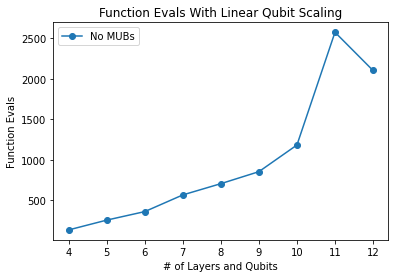

In [25]:
plot_min_nfev(n_qubit_no_mub_stats, 'No MUBs')
plt.xlabel('# of Layers and Qubits')
plt.ylabel('Function Evals')
plt.title('Function Evals With Linear Qubit Scaling')
plt.legend()
plt.show()